<a href="https://colab.research.google.com/github/rachel1234561/labs/blob/main/PCA_and_Text_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams. Some of these scam e-mails have some offensive content. I don't think anything is worse than R-rated, but I just want to warn you that if you start reading the e-mail text, you might read something offensive. If that's a problem, feel free to e-mail me and we can talk about it more or you can skip the assignment.  

### Q1.

Open the `Phishing_Email.parquet` data. It is available at `https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet`, and you can download it directly using Pandas by providing that URL: `df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')`.

We just want to look at the first step of cleaning text data, so you can get an idea of how it works. The `Email Text` variable contains the actual text of the email and the `Email Type` takes the value `Phishing Email` or `Safe Email`. We want to predict which emails are phishing emails from their contents.

Use the `str.split()` method to break the `Phishing Email` values into **tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens. Print the results of your split and examine it.

In words, how would you clean the tokens and use them to predict whether the email is a phishing scam or not? A short summary of the kinds of tasks you would do and how you would run a predictive algorithm is fine.

In [1]:
import pandas as pd
df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')

In [2]:
import numpy as np
import pickle
from collections import Counter
from multiprocessing.pool import Pool
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
tokens = df['Email Text'].str.split()
tokens.head()

,Email Text
0,"[re, :, 6, ., 1100, ,, disc, :, uniformitarian..."
1,"[the, other, side, of, *, galicismos, *, *, ga..."
2,"[re, :, equistar, deal, tickets, are, you, sti..."
3,"[Hello, I, am, your, hot, lil, horny, toy., I,..."
4,"[software, at, incredibly, low, prices, (, 86,..."


### Q2.

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [6]:
!git clone https://github.com/DS3001/PCA.git

Cloning into 'PCA'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 45 (delta 12), reused 13 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (45/45), 2.42 MiB | 8.54 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [8]:
with open('/content/PCA/05_PCA/all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)

from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

<Axes: >

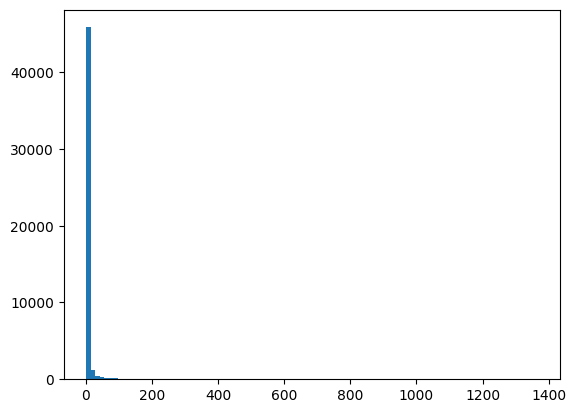

In [9]:
hist = pd.DataFrame(token_freq,columns=['token','count'])
hist['count'].hist(grid=False,bins=100)
#I notice that most words only occur >10 times, and one word that was not removed occurs ~1400 times

Plot a histogram of the occurrences of tokens. What do you notice about the frequency of occurrence of different tokens? How does it look?

### Q3.

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions?

In [13]:
df2 = pd.read_parquet('/content/PCA/05_PCA/Phishing_clean.parquet')

y = df2['Email Type']
X = df2.drop('Email Type',axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=100)


lm = LinearRegression(fit_intercept=False).fit(X_train,y_train)
y_hat_test = lm.predict(X_test)
y_hat_train = lm.predict(X_train)
print('train: ', r2_score(y_hat_train,y_train) )
print('test: ', r2_score(y_hat_test,y_test) )

train:  0.6247069991348556
test:  -4.7744715939268545e-05


In [15]:
df3 = pd.DataFrame({'variable':lm.feature_names_in_ , 'value':lm.coef_})
df3['abs'] = np.abs(df3['value'])
df3.sort_values('abs',ascending=False)
#the top entries are numbers

,variable,value,abs
74,"2002,",1.220497e+13,1.220497e+13
1014,8859,-8.298006e+12,8.298006e+12
340,2005,-5.779494e+12,5.779494e+12
915,300,5.171208e+12,5.171208e+12
1133,"19,",4.791183e+12,4.791183e+12
...,...,...,...
757,regards,2.517700e-04,2.517700e-04
752,processing,-2.136230e-04,2.136230e-04
2558,"09,",2.166366e-05,2.166366e-05
64,week,1.525879e-05,1.525879e-05


### Q4.

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

<Axes: >

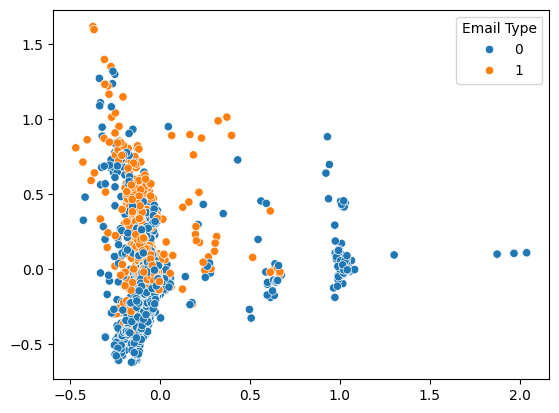

In [16]:
reduction = PCA(n_components=2).fit(X_train)
Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)
sns.scatterplot(x=Z_test[:,0],y=Z_test[:,1],hue=y_test)
#the orange dots, or scams, tend to have a low first componet. The points are pretty scattered across the y-axis

### Q5.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [17]:
reduction = PCA(n_components=2610).fit(X_train)
Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)

lm_k = LinearRegression().fit(Z_train,y_train)
y_hat_test = lm_k.predict(Z_test)
y_hat_train = lm_k.predict(Z_train)

print('Train r2: ', r2_score(y_hat_train,y_train) )
print('Test r2: ', r2_score(y_hat_test,y_test) )
#this model preformes considerably better than the original regression, especially on the test set

Train r2:  0.6967854877754098
Test r2:  0.5761002613787811


### Q6.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

the advantage of using PCA is that it reductes multicolinearity, or explanatory variables being correlated with eachother. When explanatory variables are correlated it reduces their explanatory power and leads to overfitting on the training set.